In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.neural_network import MLPClassifier, MLPRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    # Output ('good' or 'bad')
    def __init__(self, input_features=7, h1=15, h2=15, output_features=2):
        super().__init__() # instantiate our nn.Module
        self.fc1 = nn.Linear(input_features, h1) # fc, fully connected (layer)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output_features)

    # Define forward function, computes the forward pass of the NN
    def forward(self, x):
        x = F.relu(self.fc1(x)) # relu(), if output is less than 0, make it 0
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x



In [31]:
data = pd.read_csv('apple_quality.csv')
# dropping A_id
data = data.drop('A_id', axis=1)
data = data.dropna()
data['Acidity'] = data['Acidity'].astype(float)
data['Quality'] = data['Quality'].replace({'good': 1, 'bad': 0})




# display first rows of csv
data.head()

C:\Users\nicks\AppData\Local\Temp\ipykernel_24492\2462000717.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Quality'] = data['Quality'].replace({'good': 1, 'bad': 0})


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


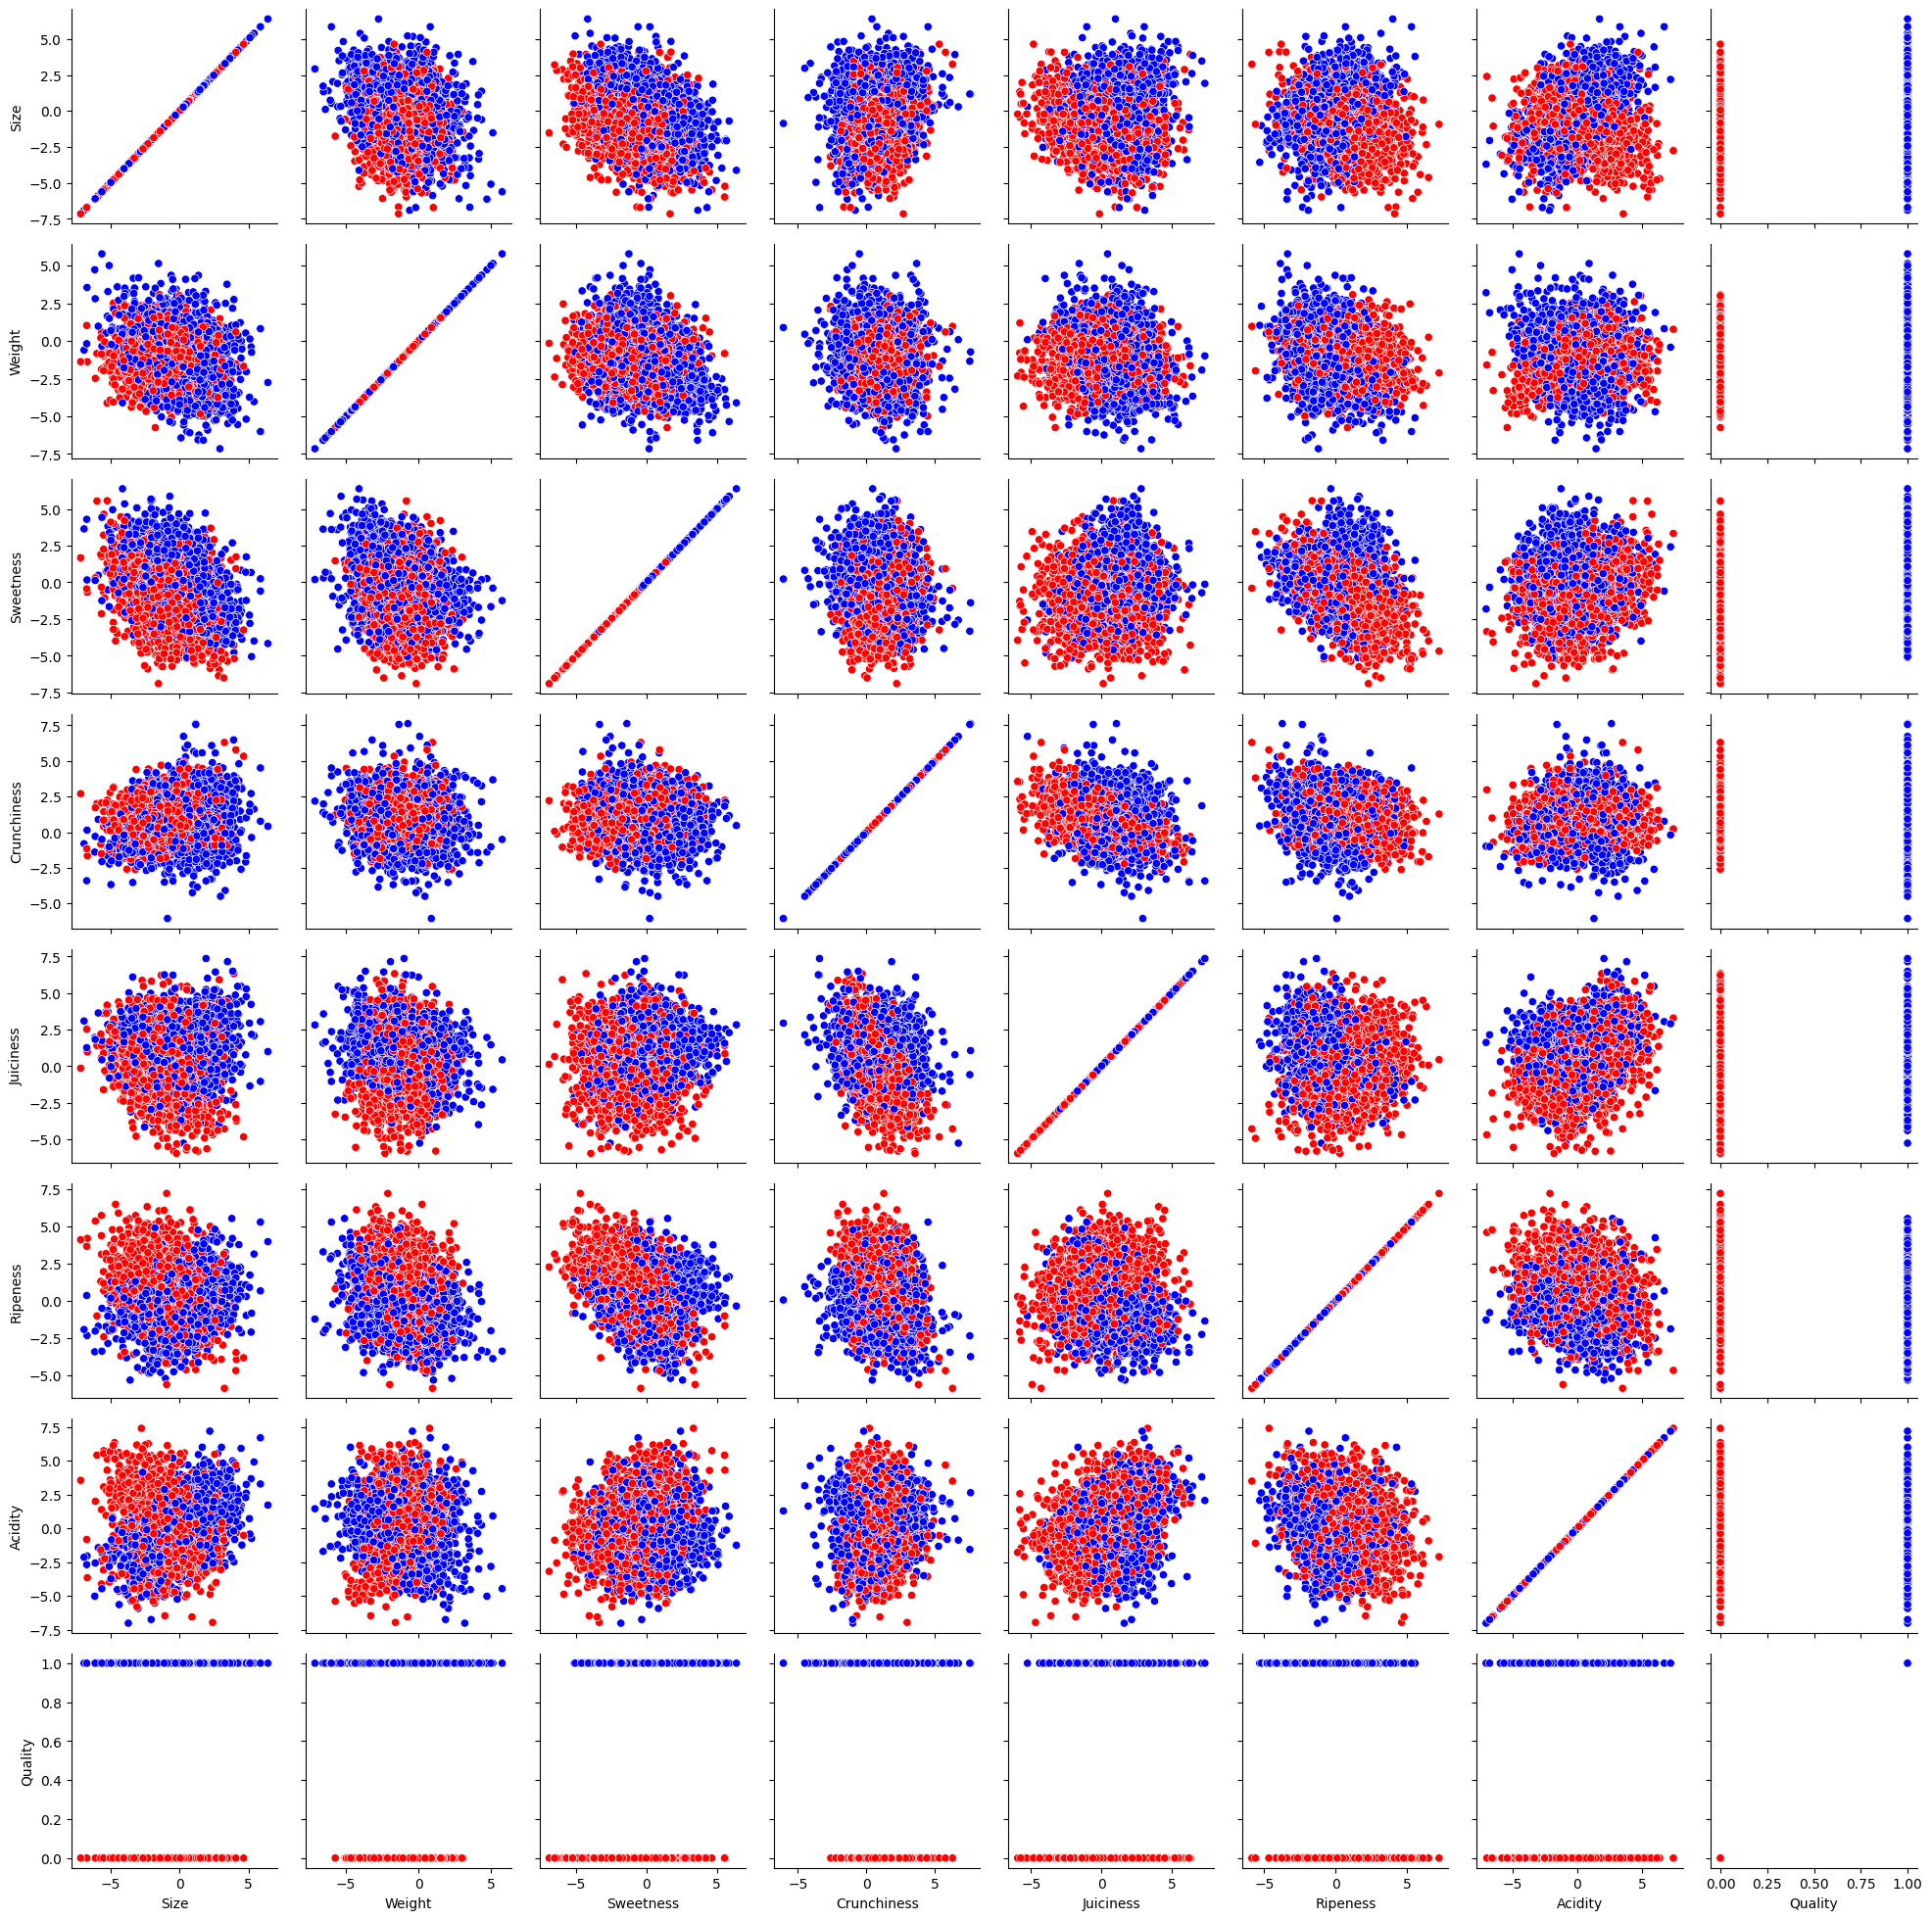

In [32]:
# Scatterplot matrix for selected predictors with hue='Quality'
selected_predictors = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Quality']
# 1 = good (blue), 0 = bad (red)
pairgrid = sns.PairGrid(data, vars=selected_predictors, hue='Quality', palette={1: 'blue', 0: 'red'})
pairgrid.map(sns.scatterplot)


plt.show()

Average and Variance of Metrics Over All Repeats:
Accuracy:  Avg = 0.7818, Var = 0.0069
Precision: Avg = 0.7970, Var = 0.0061
Recall:    Avg = 0.7683, Var = 0.0094
F1 Score:  Avg = 0.7822, Var = 0.0078


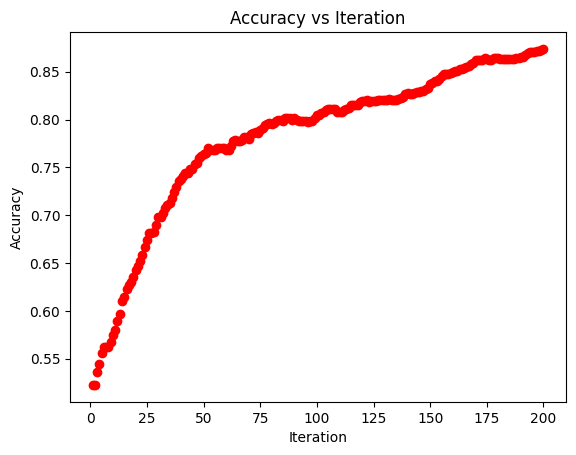

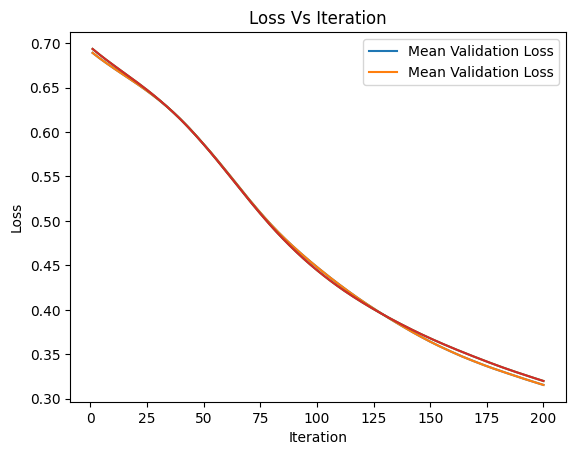

In [51]:
X = data.drop('Quality', axis=1) # Just the 7 features
y = data['Quality'] # Target variable, Quality

# Convert these to numpy arrays
X = X.values
y = y.values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.3, random_state= 42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=.3, random_state=42)

model = Model()
#Converting X values to tensor float and Y values to tenstor long 
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val) 
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #using adam evaluation

        # Training loop
acc_test = []
loss = []
val_loss = []
training_loss = []
overall_loss = []
accuracies, precisions, recalls, f1_scores = [], [], [], []


for i in range(200): 
    y_pred = model.forward(X_train) # Get predicted results
    loop_loss = []
    loop_val_loss = []    
    loss = criterion(y_pred, y_train) # predicted values vs the y_train
    
    # back propagation: feed the forward error to the back
    # through the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    y_val_pred = model.forward(X_val)  # Predict on validation set
    val_loss = criterion(y_val_pred, y_val)  # Calculate validation loss
    
    loop_loss.append(loss.item())
    loop_val_loss.append(val_loss.item())
    loop_loss.append(loss.item())
    loop_val_loss.append(val_loss.item())
    

    training_loss.append(loop_loss)
    overall_loss.append(loop_val_loss)
    
    #Evaluation
    y_test_pred = model(X_test)
            #Softmax probability
    y_test_pred_probs = F.softmax(y_test_pred, dim=1)
            #Highest probability class
    y_test_pred_labels = torch.argmax(y_test_pred_probs, dim=1)
    accuracy = (y_test_pred_labels == y_test).float().mean().item()
    acc_test.append(accuracy)

    # Converted tensors to numpy arrays
    y_test_pred_labels_np = y_test_pred_labels.numpy()
    y_test_np = y_test.numpy()

    acc = accuracy_score(y_test_np, y_test_pred_labels_np)
    prec = precision_score(y_test_np, y_test_pred_labels_np)
    rec = recall_score(y_test_np, y_test_pred_labels_np)
    f1 = f1_score(y_test_np, y_test_pred_labels_np)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    

print("Average and Variance of Metrics Over All Repeats:")
print(f"Accuracy:  Avg = {np.mean(accuracies):.4f}, Var = {np.var(accuracies):.4f}")
print(f"Precision: Avg = {np.mean(precisions):.4f}, Var = {np.var(precisions):.4f}")
print(f"Recall:    Avg = {np.mean(recalls):.4f}, Var = {np.var(recalls):.4f}")
print(f"F1 Score:  Avg = {np.mean(f1_scores):.4f}, Var = {np.var(f1_scores):.4f}")


plt.scatter(range(1, 201), acc_test, color='red', label='Test Accuracies')
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()


plt.plot(range(1, 201), overall_loss, label='Mean Validation Loss')

plt.plot(range(1, 201), training_loss, label='Mean Training Loss')
plt.legend()

plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Loss Vs Iteration")

plt.show()
